In [1]:
import sys
import os

sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("NonHermitianQW"))))


In [2]:
from operators import op
from oneDimQW import *
from twoDimQW import *
import numpy as np
from matplotlib import pyplot as plt
from numpy import pi
from numpy.linalg import eig
from scipy.linalg import expm
from berry import BerryPhase
from sympy import *

In [3]:
import ipywidgets as widgets
from ipywidgets import interact

<h1>Simple Quantum Walk</h1>

System is composed of two parts: position space with basis vectors $\{|x\rangle\}_{x=0}^{d-1}$ and coin space with basis vectors: $\{|+\rangle, |-\rangle\}$
Evolution operator is defined as: 
$$
U = S C
$$
where 
$$
S = \sum_{x=0}^{d-1} (|x+1\rangle \langle x | \otimes |+\rangle\langle + | + |x-1\rangle \langle x | \otimes |-\rangle\langle - |)
$$
and:
$$
C = \sum_{x=0}^{d-1} |x\rangle\langle x| \otimes R_{\hat{n}}(\theta,x)
$$

For the special case when $R(x,\theta)$ is independent of $x$, we can write simple form of Coin operator as:
$$
C = I \otimes \exp(-i \hat{n}\cdot \vec{\sigma}\theta)
$$

<h3>Defining parameters</h3>

In [4]:
dim = 50
coin_dict = {"th" : pi/4 , "n" : [0,1,0]}
init_state_dict = {"x0" : dim//2, "a" : 1, "b" : 1j}
steps = 100

model = one_dim_QW(dim,coin_dict,**init_state_dict)
data = model.evolve(steps)

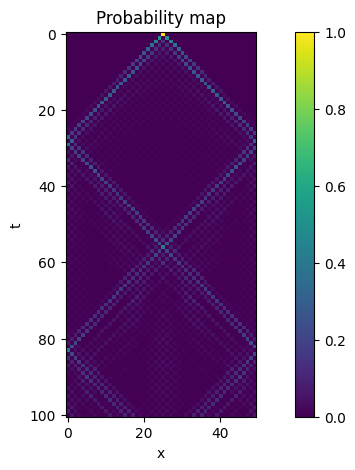

In [5]:
_,n = data.shape
x = np.arange(0,n)
fig, ax = plt.subplots(figsize = (10,5))
        
cax = ax.imshow(data,cmap = "viridis")
fig.colorbar(cax)
ax.set_ylabel("t")
ax.set_xlabel("x")
ax.set_title("Probability map")

plt.show()

<h3>Eigenspectrum</h3>

We can find the eigenspectrum of translationally invariant case, by introducing momentum basis:
$$
|k\rangle = \frac{1}{\sqrt{d}} \sum_{x=0}^{d-1}e^{-ikx}|x\rangle
$$
in which $k$ is from the first Brillouin zone. 

Stpe operator in momentum basis takes the following form:
$$
S = \sum_{x=0}^{d-1}\frac{1}{N}\sum_{j=0}^{d-1}\sum_{j' = 0 }^{d-1}( e^{-i\frac{2\pi}{d}j(x+1)}e^{i\frac{2\pi}{d}j'x}| k_{j} +\rangle\langle k_{j'}+|+e^{-i\frac{2\pi}{d}j(x-1)}e^{i\frac{2\pi}{d}j'x}| k_{j}-\rangle\langle k_{j'}-|)=
$$
$$
= \sum_{k\in BZ} (e^{-ik}|k+\rangle\langle k+| +e^{ik}|k-\rangle\langle k-|) = \sum_{k\in BZ} |k\rangle\langle k| e^{-ik\sigma_{z}}
$$
So that, the evolution operator can be written as:
$$
U = \sum_{k\in BZ} |k\rangle\langle k| e^{-ik\sigma_{z}}e^{-i\hat{n}\cdot \vec{\sigma} \theta} 
$$
On the other hand, the above operator should also look like exp function of Hamiltonian. Therefore one should be able to present it as:
$$
U \equiv \sum_{k\in BZ}|k\rangle\langle k |\exp(-i E_{k} \vec{m}\cdot \vec{\sigma} )
$$

If we take under consideration, the special, block-diagonal form of this operator in momentum basis, we can calculate the eigenspectrum, using numerical procedures. 

In [6]:
U_k = model.momentum_U()
En = - np.angle(eig(U_k)[0])

Ep, Em = En[En > 0], En[En < 0]
k = (np.arange(0,dim)-dim//2)*(2*pi/dim)

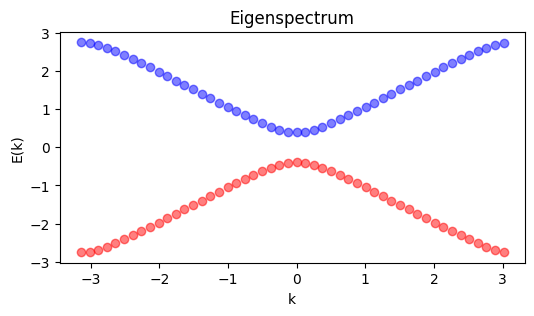

In [7]:
fig, ax = plt.subplots(figsize = (6,3))

ax.scatter(k,Ep,color="blue",alpha=0.5)
ax.scatter(k,Em,color="red",alpha=0.5)
ax.set_xlabel("k")
ax.set_ylabel(r"E(k)")
ax.set_title("Eigenspectrum")

plt.show()

As we can observe, indeed we have two bands; each of them representing the state with spin up $|\hat{m}+\rangle$ and spin down $|\hat{m}-\rangle$. 

We can also find the analytical expression for the eigenspectrum: 

In [8]:
from sympy.physics.matrices import msigma

k,nx,ny,nz,th = symbols('k,n_{x},n_{y},n_{z},theta',Reals = True)
Ek,mx,my,mz = symbols('E_{k},m_{x},m_{y},m_{z}',Reals = True)

lhs = exp(-I*k*msigma(3)) * exp(-I * (nx * msigma(1) + ny * msigma(2) + nz * msigma(3)) * th)
rhs = exp(-I * (mx * msigma(1) + my * msigma(2) + mz * msigma(3)) * Ek)

lhs = simplify(simplify(simplify(lhs).subs({nx**2+ny**2+nz**2 : 1,nx**2+ny**2 : 1-nz**2})).subs({nx**2+ny**2+nz**2 : 1,nx**2+ny**2 : 1-nz**2}))
rhs = simplify(simplify(simplify(rhs).subs({mx**2+my**2+mz**2 : 1,mx**2+my**2 : 1-mz**2})).subs({mx**2+my**2+mz**2 : 1,mx**2+my**2 : 1-mz**2}))

In [9]:
for i in range(4):
    display(Eq(2*lhs[i],2*rhs[i]))

Eq((-n_{z}*exp(2*I*theta) + n_{z} + exp(2*I*theta) + 1)*exp(-I*(k + theta)), (-m_{z}*exp(2*I*E_{k}) + m_{z} + exp(2*I*E_{k}) + 1)*exp(-I*E_{k}))

Eq((-n_{x}*exp(2*I*theta) + n_{x} + I*n_{y}*exp(2*I*theta) - I*n_{y})*exp(-I*(k + theta)), (-m_{x}*exp(2*I*E_{k}) + m_{x} + I*m_{y}*exp(2*I*E_{k}) - I*m_{y})*exp(-I*E_{k}))

Eq(I*(-I*n_{x} + n_{y} + (I*n_{x} - n_{y})*exp(2*I*theta))*exp(I*(k - theta)), I*(-I*m_{x} + m_{y} + (I*m_{x} - m_{y})*exp(2*I*E_{k}))*exp(-I*E_{k}))

Eq((n_{z}*exp(2*I*theta) - n_{z} + exp(2*I*theta) + 1)*exp(I*(k - theta)), (m_{z}*exp(2*I*E_{k}) - m_{z} + exp(2*I*E_{k}) + 1)*exp(-I*E_{k}))

In [10]:
rhsE = simplify(2*rhs[0] + 2*rhs[3])
lhsE = simplify(2*lhs[0] + 2*lhs[3])
lhsE = collect(collect(collect(collect(expand(lhsE),nz),exp(I*k)),exp(I*th)+exp(-I*th)),exp(I*th)-exp(-I*th))
lhsE = lhsE.subs({exp(I*th)+exp(-I*th) : 2 * cos(th),exp(I*th)-exp(-I*th) : 2 * I * sin(th)})
lhsE = lhsE.subs({exp(I*k)+exp(-I*k) : 2 * cos(k),exp(I*k)-exp(-I*k) : 2 * I * sin(k)})

display(simplify(Eq(lhsE/4,rhsE/4)))

Eq(cos(E_{k}), -n_{z}*sin(k)*sin(theta) + cos(k)*cos(theta))

<h1>Single step quantum walk</h1>

Single step quantum walk is defined by two rotation angles, each of them corresponds to the move in a certain direction. 
$$
U = S_{+}C(\theta_{+})S_{-}C(\theta_{-})
$$
where:
$$
S_{+} =  \sum_{x=0}^{d-1} (|x+1\rangle\langle x|\otimes |+\rangle \langle + |  + I \otimes |-\rangle \langle - |) = \sum_{k\in BZ} |k\rangle\langle k | \otimes e^{-ik(I + \sigma_{z})/2}
$$
$$
S_{-} =  \sum_{x=0}^{d-1} (I \otimes |+\rangle \langle + | + |x-1\rangle\langle x|\otimes |-\rangle \langle - |  ) = \sum_{k\in BZ} |k\rangle\langle k | \otimes e^{ik(I - \sigma_{z})/2} 
$$



<h3>Evolution and eigenspectrum</h3>

In [11]:
dim = 50
coin_dict = {"th1" : pi/4, "th2" : pi/8 , "n" : [0,1,0]}
init_state_dict = {"x0" : dim//2, "a" : 1, "b" : 1j}
steps = 100

model = ss_one_dim_QW(dim,coin_dict,**init_state_dict)
data = model.evolve(steps)

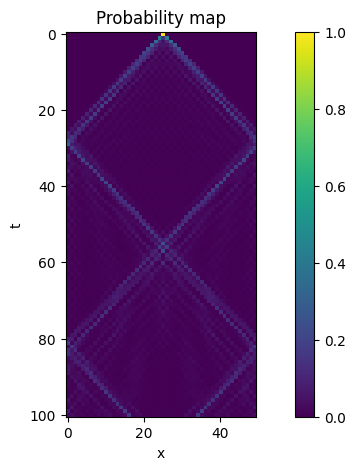

In [12]:
_,n = data.shape
x = np.arange(0,n)
fig, ax = plt.subplots(figsize = (10,5))
        
cax = ax.imshow(data,cmap = "viridis")
fig.colorbar(cax)
ax.set_ylabel("t")
ax.set_xlabel("x")
ax.set_title("Probability map")

plt.show()

In [13]:
k,nx,ny,nz = symbols('k,n_{x},n_{y},n_{z}',Reals = True)
th1,th2 = symbols('theta,phi',Reals = True)

Id = Matrix([
    [1,0],
    [0,1]
])

Sp = exp(-I*k*(Id + msigma(3))/2)
Sm = exp(I*k*(Id-msigma(3))/2) 
C = lambda th : exp(-I * (nx * msigma(1) + ny * msigma(2) + nz * msigma(3))*th)

U = Sp * C(th1) * Sm * C(th2)


lhsE_ = simplify(simplify(U).subs({nx**2+ny**2+nz**2 : 1,nx**2+ny**2 : 1-nz**2}).subs({nx : 0 , ny : 1 , nz : 0})).subs(
    {1-exp(2*I*th1): 2*I*exp(I*th1)*sin(th1),
     1+exp(2*I*th1): 2*exp(I*th1)*cos(th1),
     1-exp(2*I*th2): 2*I*exp(I*th2)*sin(th2),
     1+exp(2*I*th2): 2*exp(I*th2)*cos(th2),
      })

In [14]:
display(collect(expand(simplify((lhsE_[0]+lhsE_[1]))),exp(I*k)))

(-sin(phi)*sin(theta) - I*sin(phi)*sin(theta) + exp(-I*theta)*sin(phi) - I*exp(-I*theta)*sin(phi) - I*exp(-I*phi)*sin(theta) + exp(-I*phi)*exp(-I*theta))*exp(-I*k) - sin(phi)*sin(theta) - I*sin(phi)*sin(theta) + exp(-I*phi)*sin(theta)

In [15]:
U_k = model.momentum_U()
En = - np.angle(eig(U_k)[0])

Ep, Em = En[En > 0], En[En < 0]
k = (np.arange(0,dim)-dim//2)*(2*pi/dim)

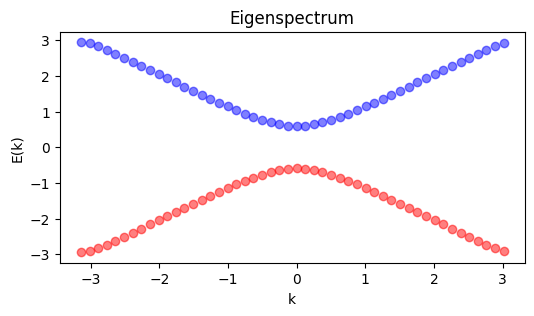

In [16]:
fig, ax = plt.subplots(figsize = (6,3))

ax.scatter(k,Ep,color="blue",alpha=0.5)
ax.scatter(k,Em,color="red",alpha=0.5)
ax.set_xlabel("k")
ax.set_ylabel(r"E(k)")
ax.set_title("Eigenspectrum")

plt.show()

<h2>Winding number for single step quantum walk</h2>

Winding number for discrete system with respect to specific band is defined as: 
$$
\gamma_{\pm} = \frac{1}{\pi}\Big|arg \big[\prod_{i=0}^{d-1}\langle \hat{n}_{\pm}(k_{i}) | \hat{n}_{\pm}(k_{i+1})\rangle \big]\Big|
$$
Where $|\hat{n}_{\pm}(k)\rangle$ is the eigenvector corresponding to specific band and specific momentum $k$. 

We can calculate the winding number for specific choice of starting parameters $(\theta_{1},\theta_{2})$

In [18]:
bp = BerryPhase(dim)

def berry_phase(th1,th2):
    coin_dict = {
        "th1" : th1,
        "th2" : th2,
        "n" : [0,1,0]
    }
    model = ss_one_dim_QW(dim,coin_dict)
    return bp.Calculate(model)

th_1 = np.arange(-2*np.pi,2*np.pi,0.1)
th_2 = np.arange(-2*np.pi,2*np.pi,0.1)
th_1, th_2 = np.meshgrid(th_1,th_2)

data_ans = np.vectorize(berry_phase)(th_1,th_2)

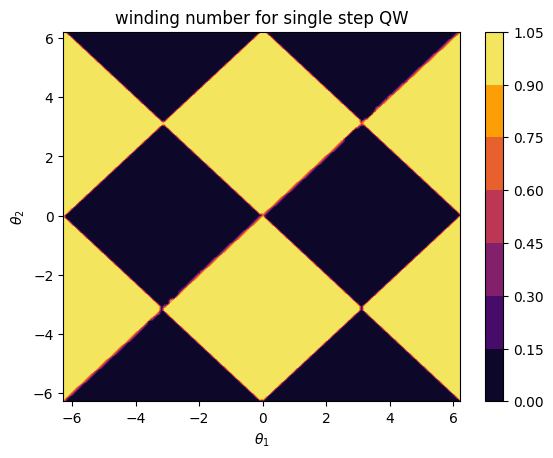

In [20]:
fig,ax = plt.subplots()

cax = ax.contourf(th_1,th_2,data_ans[0]/np.pi,cmap = "inferno")
fig.colorbar(cax)
ax.set_xlabel(r"$\theta_{1}$")
ax.set_ylabel(r"$\theta_{2}$")
ax.set_title("winding number for single step QW")

plt.show()


In [2]:
import sys
import os

sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("NonHermitianQW"))))


In [3]:
from operators import op
from oneDimQW import *
from twoDimQW import *
import numpy as np
from matplotlib import pyplot as plt
from numpy import pi
from numpy.linalg import eig
from scipy.linalg import expm
from berry import BerryPhase
from sympy import *

In [10]:
dim = 10
coin_dict = {"th1" : 3, "th2" : pi/8 , "n" : [0,1,0]}
init_state_dict = {"x0" : dim//2, "a" : 1, "b" : 1j}
steps = 100

model = ss_one_dim_QW(dim,coin_dict,**init_state_dict)
bp = BerryPhase(dim)

ns = np.real(bp.vector_representation(model))


In [11]:
print(ns.shape)

(2, 3, 10)


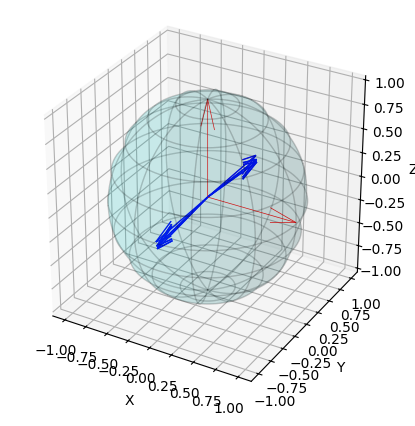

In [12]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')

u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones(np.size(u)), np.cos(v))

ax.plot_surface(x, y, z, color='c', alpha=0.1, rstride=10, cstride=10, edgecolor='black')

vectors = [
    [1, 0, 0],  
    [0, 1, 0], 
    [0, 0, 1],  
]

origin = [0, 0, 0]  
for v in vectors:
    ax.quiver(*origin, *v, color='r', linewidth=0.5,  normalize=True)

for i in range(ns[0].shape[1]):
    ax.quiver(*origin, *ns[1][:,i], color='b', linewidth=1)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_box_aspect([1, 1, 1])

plt.show()
